# <span style="color:#2c061f"> Macro 318: Tutorial #2 </span>  

<br>

## <span style="color:#374045"> Optimisation and the consumer problem </span>


#### <span style="color:#374045"> Lecturer: </span> <span style="color:#d89216"> <br> Dawie van Lill (dvanlill@sun.ac.za) </span>

# Introduction

Before getting started with this tutorial I want to acknowledge the excellent work being done by Jeppe Druedahl and his team at Copenhagen. The following tutorial is basically a port of the Python lecture for his course on numerical methods. Much of the material is directly copied, but there are also some smaller amendments to fit the 318 course. The original lecture can be found [here](https://numeconcopenhagen.netlify.app/lectures/Optimize_print_and_plot).

In this second tutorial we will be going over some basic data work and the solution of a basic optimisation problem in macroeconomics. We will report our results via text and figures, so this will entail some visualisation. 

The following packages are going to be needed for this tutorial. 

In [2]:
import Pkg

In [3]:
Pkg.add("DataFrames");
Pkg.add("Ipopt");
Pkg.add("JuMP"); # Optimisation package
Pkg.add("Optim")
Pkg.add("Plots");

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [b6b21f68] + Ipopt v0.9.1
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.2.2
  [b99e7846] + BinaryProvider v0.5.10
  [523fee87] + CodecBzip2 v0.7.2
  [b6b21f68] + Ipopt v0.9.1
  [b8f27783] + MathOptInterface v0.10.7
  [ae81ac8f] + ASL_jll v0.1.3+0
  [9cc047cb] + Ipopt_jll v300.1400.400+0
  [d00139f3] + METIS_jll v5.1.1+0
  [d7ed1dd3] + MUMPS_seq_jll v5.4.1+0
  [656ef2d0] + OpenBLAS32_jll v0.3.17+0
  [9abbd945] + Profile
Precompiling project...
  ✓ CodecBzip2
  ✓ METIS_jll
  ✓ ASL_jll
  ✓ OpenBLAS32_jll
  ✓ MUMPS_seq_jll
  ✓ Ipopt_jll
  ✓ MathOptInterface
  ✓ Ipopt
  8 dependencies successfully precompiled in 49 seconds (335 already precompiled)
   Re

In [4]:
using DataFrames
using Ipopt
using JuMP
using Optim
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


## Consumer problem

Consider the following consumer problem. You should be quite familiar with this, since it is very similar to the one that we covered in chapter 4 of Williamson last year. 

We have an economy with two goods and the following components, 

* utility function $u(x_1,x_2):\mathbb{R}^2_{+}\rightarrow\mathbb{R}$,
* exogenous income $I$, and 
* price-vector $(p_1,p_2)$,

We can write this problem as follows, 


$$
\begin{aligned}
V(p_{1},p_{2},I) & = \max_{x_{1},x_{2}}u(x_{1},x_{2})\\
 \text{s.t.}\\
p_{1}x_{1}+p_{2}x_{2} & \leq I,\,\,\,p_{1},p_{2},I>0\\
x_{1},x_{2} & \geq 0
\end{aligned}
$$

Normally these types of problems can be solved by hand. We will solve this particular problem by hand in the tutorial. If we had, for example, a Cobb-Douglas utility function, such as, 

$$
u(x_1,x_2) = x_1^{\alpha}x_2^{1-\alpha}
$$

then the solution is given by, 

$$
\begin{aligned}
x_1^{\ast} &= \alpha \frac{I}{p_1} \\
x_2^{\ast} &= (1-\alpha) \frac{I}{p_2}
\end{aligned}
$$

which implies that $\alpha$ is the budget share of the first good and $1-\alpha$ is the budget share of the second good. 

While this is not a difficult problem to solve by hand, it would be way more convenient to be able to do this on a computer. One of the main reasons is that if the utility function changes we don't need to do the whole process again, we simply need to alter the utility function in our code and we can calculate the new solution. 

## Utility function

Let us write down the utility function in terms of code. Remember how to construct functions from the first lecture? If not, please consult the section on functions. 

In [ ]:
function u_func(x1, x2, α = 0.5)
    return x1 .^ α .* x2 .^ (1 .- α)
end;

We can evaluate this utility function for different values of the inputs $x_1$ and $x_2$.

In [ ]:
x1 = 1
x2 = 3

u = u_func(x1, x2)

println("x1 = $x1, x2 = $x2 -> u = $u")

We can also loop through multiple values for $x_1$ to see how the values for the utility function changes. This reflects the elasticity of utility with respect to $x_1$

In [ ]:
x1_values = [2, 4, 6, 8, 10, 12, 14, 16]
x2 = 3

for x1 in x1_values
    u = u_func(x1, x2)

    println("x1 = $x1, x2 = $x2 -> u = $u")
end

For a little nicer output we can use the `enumerate` command, 

In [ ]:
for (i, x1) in enumerate(x1_values)
    u = u_func(x1, x2)

    println("$i: x1 = $x1, x2 = $x2 -> u = $u")
end


We can now see how utility changes with different values for $x_1$. In this case it seems that there is an increase in utility associated with an increase in $x_1$. 

In mathematical terms, it seems that the utility function is monotonically increasing with respect to changes in $x_1$. The way that we would determine the change in the utility function with respect to $x_1$ over the entire function is by using the tools of calculus. 

## Plotting the utility function

The next thing we might want to do in our analysis is to plot the utility function. We want some idea of what the function looks like graphically. We could draw it by hand, but it is much easier to utilise the computer. 

The first thing we will do is to create a 2-dimensional grid with $N$ elements in each dimension. We are going to be plotting our utility function with respect to two inputs, so we need a 2-dimensional grid. 

In [ ]:
N = 1000 # number of elements
x_max = 10 # maximum value

# Initialise the arrays with zeros
x1_values = zeros(N)
x2_values = zeros(N)
u_values = zeros(N, N);

# fill the arrays with the appropriate values
for i in 1:N
    for j in 1:N
        x1_values[i] = (i / N) * x_max 
        x2_values[j] = (j / N) * x_max
        u_values[i, j] = u_func(x1_values[i], x2_values[j])
    end
end

### Making sense of the loops

**Note** In order to understand this loop you need to take things slowly the first time. Try and understand what is happening in each step. I have provided a detailed description below, but you still need to sit and think through it. 

Let us analyse the loop above and see what is happening at each step. First, this is a nested loop. As we stated in our previous session, this means that we will be running through the $i$ component first and then the corresponding $j$ component. 

To use an example, we start with $i = 1$, and then run the loop over all the $j$ values starting at $j = 1$ and ending at $j = N = 100$. 

This means that for $i = 1$, we start with $j = 1$. This gives a value for `x1_values[1] = (1 / N) * x_max`. 

This means that the first value in the `x1_values` vector will then be $(1 / 100) * 10 = 0.1$. The same is true for `x2_values`, the first entry in that vector will be $0.1$, by the same logic as applied before. 

Now we can enter these $x_1$ and $x_2$ values into the utility function. The shape of the utility function as initialised is a $N \times N$ matrix of zeros. We are currently busy with $i = 1$ and $j = 1$. This means that in our code we are looking at `u_values[1, 1]` which is the value in the first column and first row of the matrix. 

To be clear, `u_values[1, 1]` takes on the value from the output of `u_func(0.1, 0.1)`. 

Next we keep the $i$ component fixed at $1$ and iterate over the next value in the $j$ sequence, which is $j = 2$. We repeat the steps as for the above description and end up with an entry for `u_values[1, 2]`. 

Keeping $i$ fixed, we iterate over all the values for $j$. That means for $j = 3$ to $j = 100$. After having completed this loop, we move on to a new value for $i$. 

Move on to $i = 2$ and repeat the entire process that we described above again. Looping over all the $j$ values, etc. After having done that move on to $i = 3$ and then continue the process we have described till you reach $i = 100$.

At the end of all of this you will see that we have know completely filled the `u_values` matrix with all possible combinations of $x_1$ and $x_2$ values (smaller than $x_{max} = 10$) that can enter the utility function. 

### Plotting the function

Below is the code to plot our function in three dimensions. I will provide a brief explanation on what the code is actually doing, but it should be somewhat easy to understand by just reading it. 

In [ ]:
plot_1 = plot(x1_values, x2_values, u_values, st = :surface, xlabel = "x1", ylabel = "x2", zlabel = "utility", camera = (30, 60), colour = :ice, alpha = 0.9, legend = false, x_flip = true);

We have the graph for the utility function, now we need to think about finding a solution to our **constrained optimisation** problem. We want to achieve the highest level of utility, given the constraint that we are provided. 

### Doing things the easy way

A much simpler way to construct our grids is to simply use the internal functions that Julia has for constructing grids. The reason for the previous exercise was to get you more comfortable thinking through loops and conditional statements 

We can create equally spaced grids for $x_1$ and $x_2$ in several ways. The easiest is the following, 

In [ ]:
x1_values_easy = collect(0:0.01:10); # 1001 element vector
x2_values_easy = collect(0:0.01:10);

An alternative would be to use the `LinRange` function in Julia. 

In [ ]:
x1_values_lr = LinRange(0, 10, 1000); # 1000 element vector

Using these values we can plot the utility function as before, but this time we will use a different approach, which doesn't require us to write out a whole loop for the utility function as before, 

In [1]:
plot_2 = plot(x1_values_easy, x2_values_easy, (x1_values_easy, x2_values_easy) -> u_func(x1_values_easy, x2_values_easy), st = :surface, xlabel = "x1", ylabel = "x2", zlabel = "utility", camera = (30, 60), colour = :ice, legend = false)

LoadError: UndefVarError: plot not defined

# Optimisation (finding a solution)

In this next section we talk about three ways (algorithms) for finding a solution to our original optimisation problem. Once again, remember that the problem that we want to solve is the following, 

$$
\begin{aligned}
V(p_{1},p_{2},I) & = \max_{x_{1},x_{2}}u(x_{1},x_{2})\\
 & \text{s.t.}\\
p_{1}x_{1}+p_{2}x_{2} & \leq I,\,\,\,p_{1},p_{2},I>0\\
x_{1},x_{2} & \geq 0
\end{aligned}
$$

For our first algorithm, we are basically going to loop through a grid of all the $N_{1} \times N_{2}$ solutions and then pick the best option. This has the advantage of being easy to understand. However, it requires evaluations many points and could be computationally very costly if the number of points that we need to evaluate are high. This type of method is referred to as a **grid search** method. It solves the problem with brute force. 

## Algorithm 1: Grid search

The general idea is that we will be solving the following problem. 

$$
\begin{aligned}
V(p_{1},p_{2},I) & = \max_{x_{1}\in X_1,x_{2} \in X_2} x_1^{\alpha}x_2^{1-\alpha}\\
 & \text{s.t.}\\
 x_1 & = \left\{0,\frac{1}{N_1-1}\frac{I}{p_1},\frac{2}{N_1-1}\frac{I}{p_1},\dots,\frac{I}{p_1}\right\} \\
 x_2 & = \left\{0,\frac{1}{N_2-1}\frac{I}{p_2},\frac{2}{N_2-1}\frac{ I}{p_2},\dots,\frac{ I}{p_2}\right\} \\
p_{1}x_{1}+p_{2}x_{2} & \leq I\\
\end{aligned}
$$

We are creating input grids, where the values of $x_1$ and $x_2$ are discretised. 

We discuss an example using $x_1$, but the same can be repeated for $x_2$. 

If we look at the definition of the set of values that $x_1$ can take here you will see that is always non-negative ($\geq 0$). In fact, our set starts at zero, so we take that potential value into account. 

On the other extreme with respect to the grid, we have $x_1 = I/p_1$. If you think about this carefully, $x_1$ can only take on the value of $I/p_1$ if $x_2 = 0$. This can be seen from the budget constraint $p_{1}x_{1}+p_{2}x_{2} \leq I$.

Our endpoints for the grid have now been defined as $0$ and $I/p_1$. The grid in our case is equally spaced, which means that the second point in the grid is equally far away from the first and third point. The fact that any point is equally far from adjacent points, is true for any singular point on the grid (except for the two endpoints). There is a symmetry in the spacing between points. 

The next question is, how can we create this grid mathematically so that we have this equal spacing. If there are $N_1 = 5$ grid points, then we know that the endpoints make up two of the points. So these are accounted for. Now we need to think about the other $3$ points. I call these points $x_1^2,x_1^3,x_1^4$ for now (where the superscript indicates position). 

$$
x_1 = \left\{0,x_1^2,x_1^3,x_1^4, \frac{I}{p_1}\right\}
$$

One way to think about the construction of the grid is to make a further simplification. Let us assume that we know what the end value $I/p_1$ will be. In this case we assume it is $1$ in order to make calculations a bit easier. Then we are left with the following grid, 

$$
x_1 = \left\{0,x_1^2,x_1^3,x_1^4, 1 \right\}
$$

Given that the endpoint is $1$, we know that the distances between the different values of the grid need to sum to the difference between the endpoints ($1 - 0 = 1$). For equal distances between $5$ points, where the distances must sum to one, we need the distance between each point to be $1/N_1 - 1 = 1 / 4$. If you look carefully, you will see that there are four positions in between grid points, and so we need each of these to be of length $1/4$, so that these $4$ intervals can sum to $1$.

This means that we can write the values of the grid points explicitly as, 

$$
x_1 = \left\{0,\frac{1}{4},\frac{2}{4},\frac{3}{4}, 1 \right\}
$$

Now if we have an endpoint that is equal to $I/p_1$ then we need to multiply each of the grid points with this scaling factor, so that everything sums up to that endpoint value. In other words, we will then have, 

$$
x_1 = \left\{0,\frac{1}{4}\frac{I}{p_1},\frac{2}{4}\frac{I}{p_1},\frac{3}{4}\frac{I}{p_1}, \frac{I}{p_1} \right\}
$$

As a numerical example, assume that $p_1 = 25$ and $I = 10$, then we would evaluate $x_1$ at the following values in the grid, 


$$
x_1 = \left\{0,\frac{1}{4}\frac{10}{25},\frac{2}{4}\frac{10}{25},\frac{3}{4}\frac{10}{25}, \frac{10}{25} \right\}
$$

If we simplify this a bit further we get, 

$$
x_1 = \left\{0,\frac{1}{10},\frac{2}{10},\frac{3}{10}, \frac{4}{10} \right\}
$$

For this specific example, we can then evaluate the $x_1$ along the values in this set. If we wanted we could increase the number of $N_1$ so as to evaluate along more points. This would probably give us a more accurate answer, but it comes at a computational cost. Each of these input values need to be inserted into the utility function and evaluated. The more values you have the longer it is going to take to evaluate. 

This is one of the big tradeoffs in computing. **Speed vs accuracy**. 

Now let us start coding the up! You should be excited, we are going to be solving our first economic model using programming instead of tedious calculations by hand!

### Grid search code

We will be wrapping our code block in a function. This is generally good practice. We want to operate by writing functions whenever possible. 

In [ ]:
function find_best_choice(; α, I, p1, p2, N1, N2)

    # Initialise the arrays
    x1_values = zeros(N1)
    x2_values = zeros(N2)
    u_values = zeros(N1, N2)

    # Choose a value to start with, x1 = x2 = 0
    x1_best = 0
    x2_best = 0 
    u_best = u_func(0, 0, α) # remember that u_func is a function that has already been defined. 

    # Loop through all the possibilities (all grid points)
    for i in 1:N1
        for j in 1:N2

            # Assign values for x1 and x2
            x1_values[i] = x1 = (i / (N1 - 1)) * I/p1 # Refer to the explanation above as to how this grid is constructed
            x2_values[j] = x2 = (j / (N2 - 1)) * I/p2

            # Assign values for the utility corresponding to input values
            if p1 * x1 + p2 * x2 ≤ I # If expenditure ≤ income then u(x1, x2)
                u_values[i, j] = u_func(x1, x2, α)
            else # if expenditure > income then u(0, 0)
                u_values[i, j] = u_func(0, 0, α)
            end

            # Check the best solution so far (NB part)
            if u_values[i, j] > u_best
                x1_best = x1_values[i]
                x2_best = x2_values[j]
                u_best = u_values[i, j]
            end
        end
    end

    return x1_best, x2_best, u_best, x1_values, x2_values, u_values

end

In [ ]:
sol = find_best_choice(α = 0.25, I = 10, p1 = 1,  p2 = 2, N1 = 500, N2 = 500);

In [ ]:
x1_best, x2_best, u_best, x1_values, x2_values, u_values = sol;

In [ ]:
println("Optimal x1 is $x1_best, x2 is $x2_best and u is $u_best ")

### Budget and preferences

We now have a solution to our constrained optimisation problem. We have already plotted the utility function, so let us now plot the utility function with our budget constraint and the optimal point. Remember, the budget constraint is given by, 

$$
p_{1}x_{1}+p_{2}x_{2} \leq I,\,\,\,p_{1},p_{2},I>0,\,\, x_{1},x_{2}  \geq 0
$$

We can combine the budget and utility together in a contour plot. For this problem we are going to assume that $p1 = 1$, $p2 = 2$ and that $I = 10$.

In [4]:
p1 = 1;
p2 = 2;
I = 10;

In [5]:
x = 0:0.01:10

b = collect(0:0.5:10);
c(z) = 10 - 2 .* z;

plot_3 = plot(x, x, (x, y) -> u_func(x, y), st = :contour, colour = :ice, levels = b, legend = false);

plot!(plot_3, c, 0.01, 10, ylims = (0,10), lw = 1.5, color = :black, fill=(0,0.5,:blue))
scatter!(plot_3, [3.75], [2.5], markersize = 5, markercolor = :red) # This includes the solution, but we haven't calculated this answer yet. 


LoadError: UndefVarError: plot not defined

## Algorithm 2: Using a Solver (Optim)

The best option is to try and use code that someone else has written. 

Sometimes it is useful to write your own routines if no other option is available. However, if you can make use of a package from a professional software developer that is the first prize. 

Do not try and reinvent the wheel. Some of you might end of being software engineers, and then you can spend countless hours trying to write performant code. However, most of you are going to use code for a specific goal.

My ideal world is one where everyone knows something about software engineering and we students are aware of best programming practices. However, I am aware not everyone is interested in these topics. 

In this section we will be making use of `Optim.jl`. This package does not allow constrained optimisation, so we are going to have to be a bit creative with respect to the construction of constraints for the problem. 

We will be working with a package that deals directly with constrained optimisation for problems with nonlinear objective functions in the next section, but it is worthwhile seeing what `Optim.jl` can do in the meantime. 



### Optimisation with one choice variable

To use this package, let us first start with an easy unconstrained optimisation problem with one choice variable. 

In [31]:
fn_opt(x) = 2 * (x - 5)^2 - 20

fn_opt (generic function with 1 method)

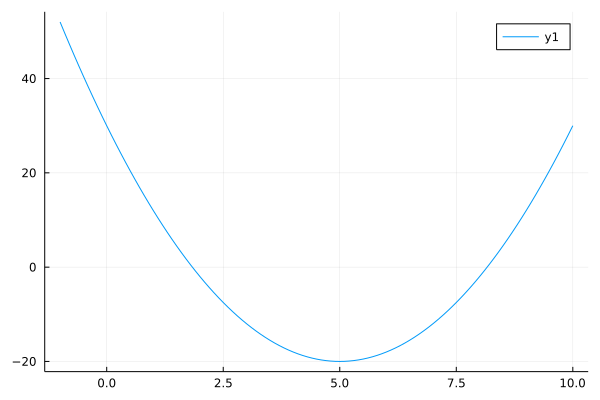

In [18]:
x = -1:0.1:10

plot(x, fn_opt_1.(x))

In [32]:
res = optimize(fn_opt, -1.0, 10.0) # looks in the interval between -1 and 10 using Brent's method

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-1.000000, 10.000000]
 * Minimizer: 5.000000e+00
 * Minimum: -2.000000e+01
 * Iterations: 5
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 6

### Optimisation with several choice variables

In [33]:
function value_of_choice(x)

    α = 0.25
    I = 10
    p1 = 1
    p2 = 2

    x1 = x[1]
    x2 = x[2]

    penalty = 0

    exp = p1 * x1 + p2 * x2 # total expenses

    if exp > I # expenses > income is not allowed
        fac = I/exp
        penalty = penalty + 1000 * (exp - I) # calculate the penalty
        x1 = x1 * fac
        x2 = x2 * fac
    end

    return -u_func(x1, x2, α) + penalty
end

value_of_choice (generic function with 1 method)

In [34]:
I = 10
p1 = 1
p2 = 2

initial_x = [I/p1/2, I/p2/2]

res = optimize(value_of_choice, initial_x)

LoadError: UndefVarError: u_func not defined

In [ ]:
Optim.minimizer(res) 

## Algorithm 3: Using a Solver (JuMP)

In the next section we will use a really cool package called `JuMP.jl` to solve the model.

In [ ]:
model = Model(Ipopt.Optimizer)
@variable(model, x1 >= 0)
@variable(model, x2 >= 0)
@NLobjective(model, Max, x1 ^ 0.25 * x2 ^ 0.75)
@NLconstraint(model, x1 + 2x2 <= 10)
print(model)

In [ ]:
optimize!(model)

In [ ]:
@show value(x1)

In [ ]:
@show value(x2)

If we compare these values to our solution from before we will see that they are quite similar. 